In [107]:
import numpy as np
import os,sys
sys.path.append(os.path.realpath('/Users/jaredgridley/Projects/CryptoResearch2023/Papers/FGW/lib'))
from graph import graph_colors,draw_rel,draw_transp,Graph,wl_labeling
from ot_distances import Fused_Gromov_Wasserstein_distance,Wasserstein_distance
import copy
from data_loader import load_local_data,histog,build_noisy_circular_graph
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pickle
import ot

In [4]:
sushi_liquidity = pd.read_csv("sushi_liquidity_positions.csv")

sushi_liquidity_snaps = pd.read_csv("sushi_liquidity_position_snapshots.csv")

sushi_pool_creators = pd.read_csv("sushi_pool_creators.csv")

In [12]:
# Create User Features
sushi_user_creations = sushi_pool_creators["contractCreator"].value_counts()
sushi_users = sushi_liquidity["user.id"].drop_duplicates()
sushi_tokens = list(set(sushi_liquidity["pair.token0.id"]).union(
    set(sushi_liquidity["pair.token1.id"])))
sushi_pools = sushi_liquidity["pair.id"].drop_duplicates()

# First time uncomment this
# users_to_feats = dict()
# tokens_to_feats = dict()
pools_to_feats = dict()

file = open('sushi_feature_dicts.pkl', 'rb')
d = pickle.load(file)
users_to_feats = d[0]
tokens_to_feats = d[1]
file.close()


In [ ]:
# Create User Features 2

for add in sushi_users:
    if add not in users_to_feats.keys():
        feats = {"uniq_neighbors": -1, "liq_snaps": -
                1, "pools_created": 0, "avg_snaps_pool": -1}

        user_snaps = sushi_liquidity_snaps[sushi_liquidity_snaps["user.id"] == add]
        user_snap_feats = user_snaps.nunique()

        feats["uniq_neighbors"] = user_snap_feats["pair.id"]
        feats["liq_snaps"] = user_snap_feats["id"]
        feats["avg_snaps_pool"] = np.mean(
            user_snaps["pair.id"].value_counts().values)

        if add in sushi_user_creations:
            feats["pools_created"] = sushi_user_creations[add]

        users_to_feats[add] = feats
  


In [ ]:
# Token Features 2

for add in sushi_tokens:
    if add not in tokens_to_feats.keys():
        feats = {"uniq_neighbors": 0, "liq_snaps": -1,
                 "pools_created": -1, "avg_snaps_pool": -1}

        token_snaps = sushi_liquidity_snaps[(sushi_liquidity_snaps["pair.token0.id"]
                                            == add) | (sushi_liquidity_snaps["pair.token1.id"] == add)]
        token_snap_stats = token_snaps.nunique()

        feats["uniq_neighbors"] = token_snap_stats["user.id"]

        tokens_to_feats[add] = feats


In [18]:
# Liqudity Pool features


for add in sushi_pools:
    feats = {"uniq_neighbors": 0, "liq_snaps": -1, "pools_created": -1, "avg_snaps_pool": -1}
    
    pool_snaps = sushi_liquidity[sushi_liquidity["pair.id"] == add]
    pool_snap_feats = pool_snaps.nunique()
    feats["uniq_neighbors"] = pool_snap_feats["user.id"]

    pools_to_feats[add] = feats


In [19]:
file = open('sushi_feature_dicts_lg.pkl', 'wb')
pickle.dump([users_to_feats, tokens_to_feats, pools_to_feats], file)
file.close()


In [21]:
len(pools_to_feats)

3535

In [131]:
avail_liq = sushi_liquidity[sushi_liquidity["user.id"].isin(users_to_feats.keys())]
avail_liq = avail_liq[(avail_liq["pair.token0.id"].isin(tokens_to_feats.keys())) &
                      (avail_liq["pair.token1.id"].isin(tokens_to_feats.keys()))]
avail_liq = avail_liq[avail_liq["pair.id"].isin(pools_to_feats.keys())]

users = avail_liq["user.id"].drop_duplicates()

# Graph 1 sample
users1 = users.sample(6, random_state=8)
user1_w_feats = {key: users_to_feats[key] for key in users1}
user1_vec_feats = {key: np.array(list(users_to_feats[key].values())) for key in users1}

graph1_df = avail_liq[avail_liq["user.id"].isin(users1)]

tokens1 = set(graph1_df["pair.token0.id"]).union(
    set(graph1_df["pair.token1.id"]))
tokens1_w_feats = {key: tokens_to_feats[key] for key in list(tokens1)}
tokens1_vec_feats = {key: np.array(list(tokens_to_feats[key].values())) for key in tokens1}


pools1 = set(graph1_df["pair.id"])
pool1_w_feats = {key: pools_to_feats[key] for key in list(pools1)[0:8]}
pool1_vec_feats = {key: np.array(list(pools_to_feats[key].values())) for key in list(pools1)}

# Graph 2 sample
users2 = users.sample(4, random_state=6)
user2_w_feats = {key: users_to_feats[key] for key in users2}
user2_vec_feats = {key: np.array(list(users_to_feats[key].values())) for key in users2}

graph2_df = avail_liq[avail_liq["user.id"].isin(users2)]

tokens2 = list(set(graph2_df["pair.token0.id"]).union(
               set(graph2_df["pair.token1.id"])).intersection(
               set(tokens_to_feats.keys())))
tokens2_w_feats = {key: tokens_to_feats[key] for key in list(tokens2)}
tokens2_vec_feats = {key: np.array(list(tokens_to_feats[key].values())) for key in tokens2}

pools2 = set(graph2_df["pair.id"])
pool2_w_feats = {key: pools_to_feats[key] for key in list(pools2)}
pool2_vec_feats = {key: np.array(list(pools_to_feats[key].values())) for key in list(pools2)}



In [132]:
def create_graphs1(users_w_feats, tokens_w_feats, pools_w_feats, df):
    # works only for setups like in cell above
    G = nx.Graph()
    G.add_nodes_from(users_w_feats)
    G.add_nodes_from(tokens_w_feats)
    G.add_nodes_from(pools_w_feats)

    el = set((row["pair.id"], row["pair.token0.id"]) for i, row in df.iterrows()).union(
        set((row["pair.id"], row["pair.token1.id"])for i, row in df.iterrows()))
    el2 = set((row["user.id"], row["pair.id"])for i, row in df.iterrows())

    G.add_edges_from(el)
    G.add_edges_from(el2)
    G.remove_nodes_from(list(nx.isolates(G)))

    colors = []
    for node in G:
        if node in tokens_w_feats.keys():
            colors.append("blue")
        elif node in pools_w_feats.keys():
            colors.append("green")
        else:
            colors.append("orange")

    G = nx.convert_node_labels_to_integers(G, ordering="default")
    # Now for the paper graph
    g = Graph()
    g.add_attibutes(users_w_feats)
    g.add_attibutes(tokens_w_feats)
    g.add_attibutes(pools_w_feats)
    for e in el:
        g.add_edge(e)
    for e in el2:
        g.add_edge(e)

    return G, g, colors


In [133]:
G1_d, g1_d, colors1 = create_graphs1(user1_w_feats, tokens1_w_feats, pool1_w_feats, graph1_df)
G2_d, g2_d, colors2 = create_graphs1(user2_w_feats, tokens2_w_feats, pool2_w_feats, graph2_df)

G1_e, g1_e, colors1 = create_graphs1(user1_vec_feats, tokens1_vec_feats, pool1_vec_feats, graph1_df)
G2_e, g2_e, colors2 = create_graphs1(user2_vec_feats, tokens2_vec_feats, pool2_vec_feats, graph2_df)

In [134]:
print(G1_d)
print(G2_d)

Graph with 17 nodes and 17 edges
Graph with 20 nodes and 22 edges


Graph with 17 nodes and 17 edges
Graph with 20 nodes and 22 edges


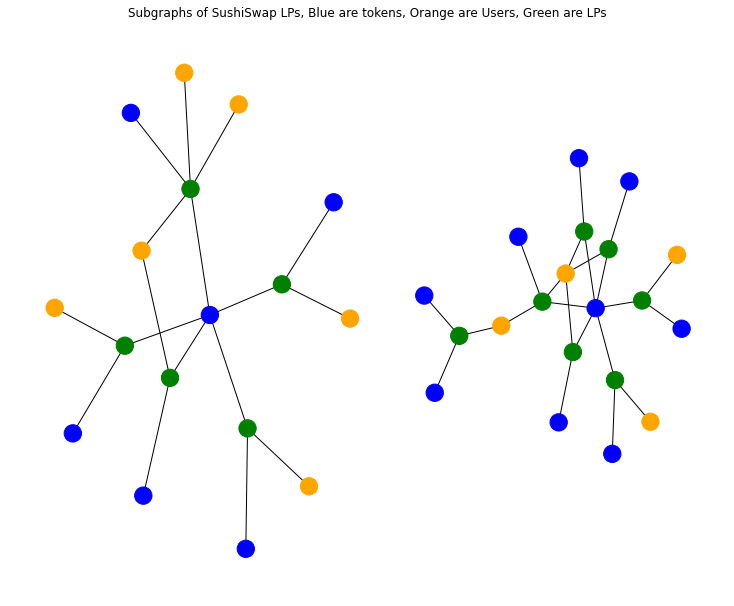

In [135]:
plt.figure(figsize=(10, 8))
vmin = 0
vmax = 7

draw_rel(G1_d, draw=False, vmin=vmin, vmax=vmax,
         with_labels=False, colors=colors1)
print(G1_d)
draw_rel(G2_d, draw=False, vmin=vmin, vmax=vmax,
         with_labels=False, shiftx=2.5, swipy=True, colors=colors2)
print(G2_d)
plt.title('Subgraphs of SushiSwap LPs, Blue are tokens, Orange are Users, Green are LPs')

plt.show()


In [ ]:
G = nx.Graph()


In [76]:
for u in g1_d.nx_graph.nodes:
    print(u, len([n for n in g1_d.nx_graph.neighbors(u)]))


0xbe83998dcf16c06524ced96f19e5f860d736c5ea 1
0x79e14e09e99348dbda367a594eddca08a7fce728 1
0xd596d58285bdde7cbf4070f448e92f9aa69e329c 1
0x9990590d649e8b8808a3a7a427e357995970806f 1
0xb22e537e10e798fff2376f24c7a39e7c68702349 2
0xd7445a64d715b3f7577c023a8ab60fb7a79aaa17 1
0x27044a95e9fb005aa7e6c0c3659aa836e9ce9cc0 2
0xdb8eb119800a162017e669ccc5910cd65d6ff96a 2
0xa0a6b1a7914079003258c6b627c215beab719e06 2
0xec87a23c591a457832c80f961e82eb88179bdff5 2
0xc00e94cb662c3520282e6f5717214004a7f26888 1
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2 8
0xba11d00c5f74255f56a5e366f4f77f5a186d7f55 1
0x57ab1ec28d129707052df4df418d58a2d46d5f51 1
0x9d47894f8becb68b9cf3428d256311affe8b068b 1
0xdac17f958d2ee523a2206206994597c13d831ec7 1
0x6b3595068778dd592e39a122f4f5a5cf09c90fe2 1
0x67e475577b4036ee4f0f12fa2d538ed18cef48e3 3
0x795065dcc9f64b5614c407a6efdc400da6221fb0 7
0xa1d7b2d891e3a1f9ef4bbc5be20630c2feb1c470 3
0xa75f7c2f025f470355515482bde9efa8153536a8 3
0x31503dcb60119a812fee820bb7042752019f2355 3
0xf1f85b2c

In [78]:
[n for n in g1_d.nx_graph.neighbors(
    "0x795065dcc9f64b5614c407a6efdc400da6221fb0")]


['0x6b3595068778dd592e39a122f4f5a5cf09c90fe2',
 '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2',
 '0x9990590d649e8b8808a3a7a427e357995970806f',
 '0x27044a95e9fb005aa7e6c0c3659aa836e9ce9cc0',
 '0xbe83998dcf16c06524ced96f19e5f860d736c5ea',
 '0xb22e537e10e798fff2376f24c7a39e7c68702349',
 '0xdb8eb119800a162017e669ccc5910cd65d6ff96a']

In [136]:
alpha = 0.5
dfgw = Fused_Gromov_Wasserstein_distance(
    alpha=alpha, features_metric='dirac', method='shortest_path').graph_d(g1_d, g2_d)
dw = Wasserstein_distance(features_metric='dirac').graph_d(g1_d, g2_d)
dgw = Fused_Gromov_Wasserstein_distance(
    alpha=1, features_metric='dirac', method='shortest_path').graph_d(g1_d, g2_d)
print('Wasserstein distance={}, Gromov distance={} \nFused Gromov-Wasserstein distance for alpha {} = {}'.format(dw, dgw, alpha, dfgw))


Wasserstein distance=0.7499999999999998, Gromov distance=1.243858131488034 
Fused Gromov-Wasserstein distance for alpha 0.5 = 1.1620501730109103


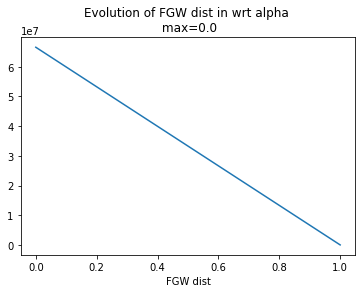

In [137]:
# We plot the evolution of the FGW distance with respect to the alpha parameter
alld = []
x = np.arange(0, 1.01, 0.05)
xn = []
for alpha in x:
    try:
        d = Fused_Gromov_Wasserstein_distance(
            alpha=alpha, features_metric='sqeuclidean', method='shortest_path').graph_d(g1_e, g2_e)
        alld.append(d)
        xn.append(alpha)
    except:
        print("Error with alpha=" + str(alpha))
plt.plot(xn, alld)
plt.title('Evolution of FGW dist in wrt alpha \n max={}'.format(
    x[np.argmax(alld)]))
plt.xlabel('Alpha')
plt.xlabel('FGW dist')
plt.show()


In [138]:
C1 = g1_e.distance_matrix(method="shortest_path")   # structural info
C2 = g2_e.distance_matrix(method="shortest_path")

nodes1 = g1_e.nodes()
nodes2 = g2_e.nodes()
t1masses = np.ones(len(nodes1))/len(nodes1)     #prob distbution
t2masses = np.ones(len(nodes2))/len(nodes2)

x1 = g1_e.reshaper(g1_e.all_matrix_attr())          # feature info
x2 = g2_e.reshaper(g2_e.all_matrix_attr())
M = ot.dist(x1, x2, metric="sqeuclidean")


In [139]:
r, log = ot.gromov.fused_gromov_wasserstein(M, C1, C2, t1masses, t2masses, log=True)

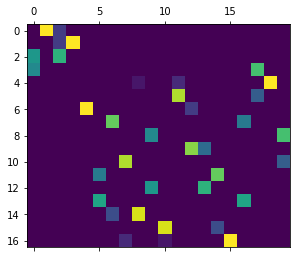

In [140]:
plt.matshow(r)

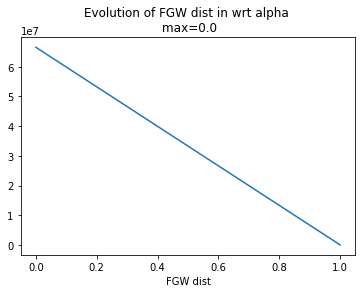

In [141]:
# We plot the evolution of the FGW distance with respect to the alpha parameter
alld = []
x = np.arange(0, 1.01, 0.01)

for alpha in x:
    try:
        d, log = ot.gromov.fused_gromov_wasserstein(
            M, C1, C2, t1masses, t2masses, alpha=alpha, log=True)
        alld.append(log["fgw_dist"])
    except:
        print("Error with alpha=" + str(alpha))
plt.plot(x, alld)
plt.title('Evolution of FGW dist in wrt alpha \n max={}'.format(
    x[np.argmax(alld)]))
plt.xlabel('Alpha')
plt.xlabel('FGW dist')
plt.show()

# masses should be shifted to represent a priori information. 

In [120]:
log

{'loss': [2.034680113198117,
  0.570097281609757,
  0.3676338003535734,
  0.30811297834797,
  0.2950957253514713,
  0.29156083952305745,
  0.2889053277776982,
  0.2862204719173773,
  0.28406246394498125,
  0.28239184402819745,
  0.2813894377636925,
  0.2807276620259934,
  0.2802059023518155,
  0.28012734254871885,
  0.2800610629115298,
  0.27997580123672067,
  0.2799493500919845,
  0.27985901340128494,
  0.2798536409936866,
  0.27984977842090986,
  0.27984467876902086,
  0.2797958150237449,
  0.2797013042908427,
  0.2794857674507448,
  0.2794230002031895,
  0.27936304849843613,
  0.2793243295058,
  0.27915493589274226,
  0.2782541012145662,
  0.2777646877278567,
  0.2777454980439728,
  0.27771159011010604,
  0.27764745908401034,
  0.2776387062653316,
  0.27763039513492493,
  0.2776252462110348,
  0.2776230641653627,
  0.2776230641653627],
 'cost': 0.6529452285258076,
 'u': array([ 1.47890316e-01, -7.82145142e-02, -1.65720020e-01,  1.47890316e-01,
         2.90516740e-01, -1.45081137e-0

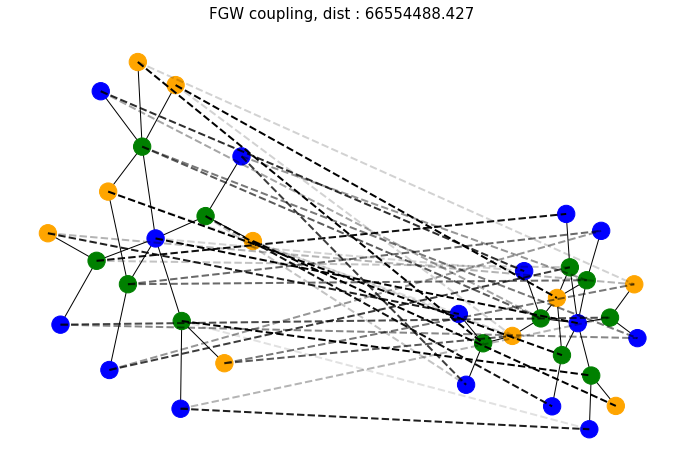

In [144]:
fig = plt.figure(figsize=(12, 8))
thresh = 0.004
gwdist = Fused_Gromov_Wasserstein_distance(
    alpha=0, features_metric='sqeuclidean')
d = gwdist.graph_d(g1_e, g2_e)
plt.title('FGW coupling, dist : '+str(np.round(d, 3)), fontsize=15)
draw_transp(g1_e, g2_e, gwdist.transp, shiftx=4, shifty=0.5, thresh=thresh,
            swipy=True, swipx=False, with_labels=False, vmin=vmin, vmax=vmax, colors=[colors1, colors2])
plt.show()


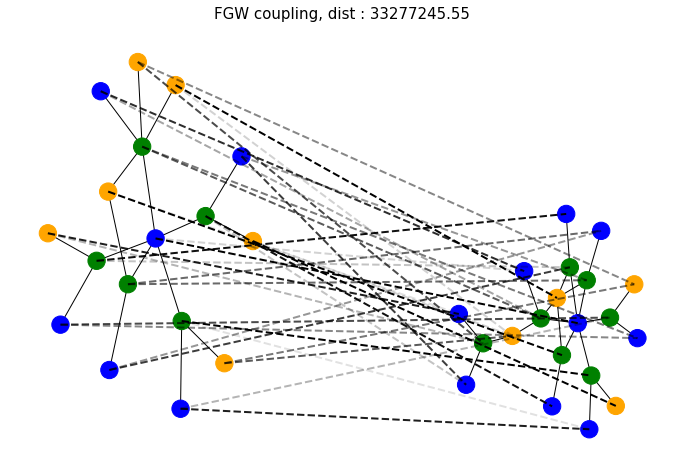

In [145]:
fig = plt.figure(figsize=(12, 8))
thresh = 0.004
gwdist = Fused_Gromov_Wasserstein_distance(
    alpha=0.5, features_metric='sqeuclidean')
d = gwdist.graph_d(g1_e, g2_e)
plt.title('FGW coupling, dist : '+str(np.round(d, 3)), fontsize=15)
draw_transp(g1_e, g2_e, gwdist.transp, shiftx=4, shifty=0.5, thresh=thresh,
            swipy=True, swipx=False, with_labels=False, vmin=vmin, vmax=vmax, colors=[colors1, colors2])
plt.show()


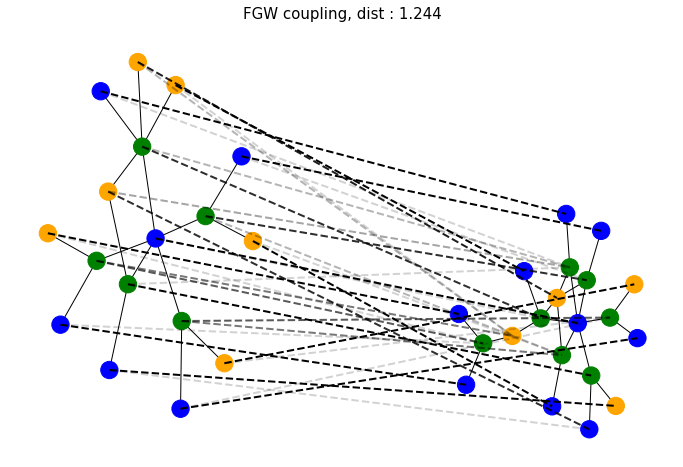

In [146]:
fig = plt.figure(figsize=(12, 8))
thresh = 0.004
gwdist = Fused_Gromov_Wasserstein_distance(
    alpha=1, features_metric='sqeuclidean')
d = gwdist.graph_d(g1_e, g2_e)
plt.title('FGW coupling, dist : '+str(np.round(d, 3)), fontsize=15)
draw_transp(g1_e, g2_e, gwdist.transp, shiftx=4, shifty=0.5, thresh=thresh,
            swipy=True, swipx=False, with_labels=False, vmin=vmin, vmax=vmax, colors=[colors1, colors2])
plt.show()
